In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import os
from dotenv import load_dotenv
import time
from pathlib import Path

from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed


try:
    # For scripts, __file__ is defined
    parent_dir = os.path.abspath(os.path.dirname(os.path.realpath(__file__)))
except NameError:
    # For interactive environments (e.g., Jupyter), use the current working directory
    pass
    parent_dir = os.path.abspath(os.path.dirname(os.getcwd()))

print(f"Parent Directory: {parent_dir}")


Parent Directory: d:\alib\LPCVC2023


In [63]:
class_names = {'0': 'background',
 '1': 'avalanche',
 '2': 'building_undamaged',
 '3': 'building_damaged',
 '4': 'cracks/fissure/subsidence',
 '5': 'debris/mud//rock flow',
 '6': 'fire/flare',
 '7': 'flood/water/river/sea',
 '8': 'ice_jam_flow',
 '9': 'lava_flow',
 '10': 'person',
 '11': 'pyroclastic_flow',
 '12': 'road/railway/bridge',
 '13': 'vehicle'}

class_color_maps = {'0': (0, 0, 0), # background -> black
 '1': (234, 155, 162),
 '2': (211, 78, 67),
 '3': (237, 231, 159),
 '4': (145, 209, 61),
 '5': (137, 193, 198),
 '6': (27, 230, 195),
 '7': (52, 138, 174),
 '8': (216, 86, 141),
 '9': (243, 157, 207),
 '10': (118, 176, 70),
 '11': (238, 173, 77),
 '12': (205, 219, 90),
 '13': (43, 56, 153)}



In [64]:
# define a function to annotate the classes in the mask
def annotate_classes(mask):
    h, w = mask.shape[:2]
    annotated_mask = np.zeros((h, w, 3), dtype=np.uint8)

    for class_id, color in class_color_maps.items():
        annotated_mask[mask == int(class_id)] = color
    return annotated_mask

In [65]:
# Define the number of classes
num_classes = len(class_names)

# path to the dataset:
# load_dotenv(os.path.join(parent_dir, ".env"))
load_dotenv(os.path.join(parent_dir, "..", ".env"))

# train_path = os.path.normpath(os.getenv("DATASET_PATH"))
# gt_path = os.path.normpath(os.getenv("GT_PATH"))

train_path = "D:/alib/LPCVC2023/data/LPCVC_Train_Updated/LPCVC_Train_Updated/LPCVC_Train_Updated/IMG/train"
gt_path = "D:/alib/LPCVC2023/data/LPCVC_Train_Updated/LPCVC_Train_Updated/LPCVC_Train_Updated/GT_Updated/train"
train_path

'D:/alib/LPCVC2023/data/LPCVC_Train_Updated/LPCVC_Train_Updated/LPCVC_Train_Updated/IMG/train'

In [76]:
def plot_images(train_data_path, gt_data_path, num_images):
    # Get list of all image files
    all_files = [f for f in os.listdir(train_data_path) if f.endswith('.png')]
    print(f"Total images found: {len(all_files)}")
    
    # Randomly select num_images from all files
    selected_files = random.sample(all_files, min(num_images, len(all_files)))
    print(f"Selected images: {selected_files}")
    
    # Load images from file_path
    train_images = []
    gt_images = []
    gt_images_pixels_counts = []

    for img_file in selected_files:
        # Construct full file paths
        train_img_path = os.path.join(train_data_path, img_file)
        gt_img_path = os.path.join(gt_data_path, img_file)
        
        print(f"Loading: {img_file}")

        # Check if files exist
        if not os.path.exists(train_img_path) or not os.path.exists(gt_img_path):
            print(f"Warning: Could not find image pair {img_file}")
            continue

        # Load images
        train_image = cv2.imread(train_img_path)
        if train_image is not None:
            train_image = cv2.cvtColor(train_image, cv2.COLOR_BGR2RGB)
        else:
            print(f"Error loading train image {train_img_path}")
            continue

        gt_image = cv2.imread(gt_img_path, cv2.IMREAD_GRAYSCALE)
        if gt_image is None:
            print(f"Error loading GT image {gt_img_path}")
            continue

        # Store images and compute pixel counts
        train_images.append(train_image)
        unique_pixels, counts = np.unique(gt_image, return_counts=True)
        gt_images_pixels_counts.append({'uniq_pixels': unique_pixels, 'counts': counts})
        gt_images.append(annotate_classes(gt_image))

    if not train_images:
        print("No images were successfully loaded!")
        return

    # Rest of the plotting code remains the same...
    # Create figure with subplots
    fig, axes = plt.subplots(len(train_images), 3, 
                            figsize=(2*5 + 15, len(train_images)*5), 
                            gridspec_kw={'width_ratios': [20, 20, 60]})

    # Handle case where only one image is plotted
    if len(train_images) == 1:
        axes = axes.reshape(1, -1)

    # Plot each image pair
    for i, (train_image, gt_image) in enumerate(zip(train_images, gt_images)):
        # Plot training image
        axes[i, 0].imshow(train_image)
        axes[i, 0].set_title(f'Training Image: {selected_files[i]}')  # Added filename to title
        axes[i, 0].set_xticks([])
        axes[i, 0].set_yticks([])

        # Plot ground truth image
        axes[i, 1].imshow(gt_image)
        axes[i, 1].set_title('Ground Truth')
        axes[i, 1].set_xticks([])
        axes[i, 1].set_yticks([])

        # Plot class distribution
        gt_image_counts = gt_images_pixels_counts[i]
        gt_image_classes_to_counts = dict(zip(gt_image_counts['uniq_pixels'], 
                                            gt_image_counts['counts']))
        gt_image_class_names_to_counts = {
            class_names[str(class_idx)]: class_counts
            for class_idx, class_counts in gt_image_classes_to_counts.items()
        }

        axes[i, 2].bar(list(gt_image_class_names_to_counts.keys()), 
                      list(gt_image_class_names_to_counts.values()))
        axes[i, 2].set_title('Class Distribution')
        axes[i, 2].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

Total images found: 1021
Selected images: ['train_0900.png', 'train_0978.png', 'train_0443.png', 'train_0131.png', 'train_0929.png']
Loading: train_0900.png
Loading: train_0978.png
Loading: train_0443.png
Loading: train_0131.png
Loading: train_0929.png


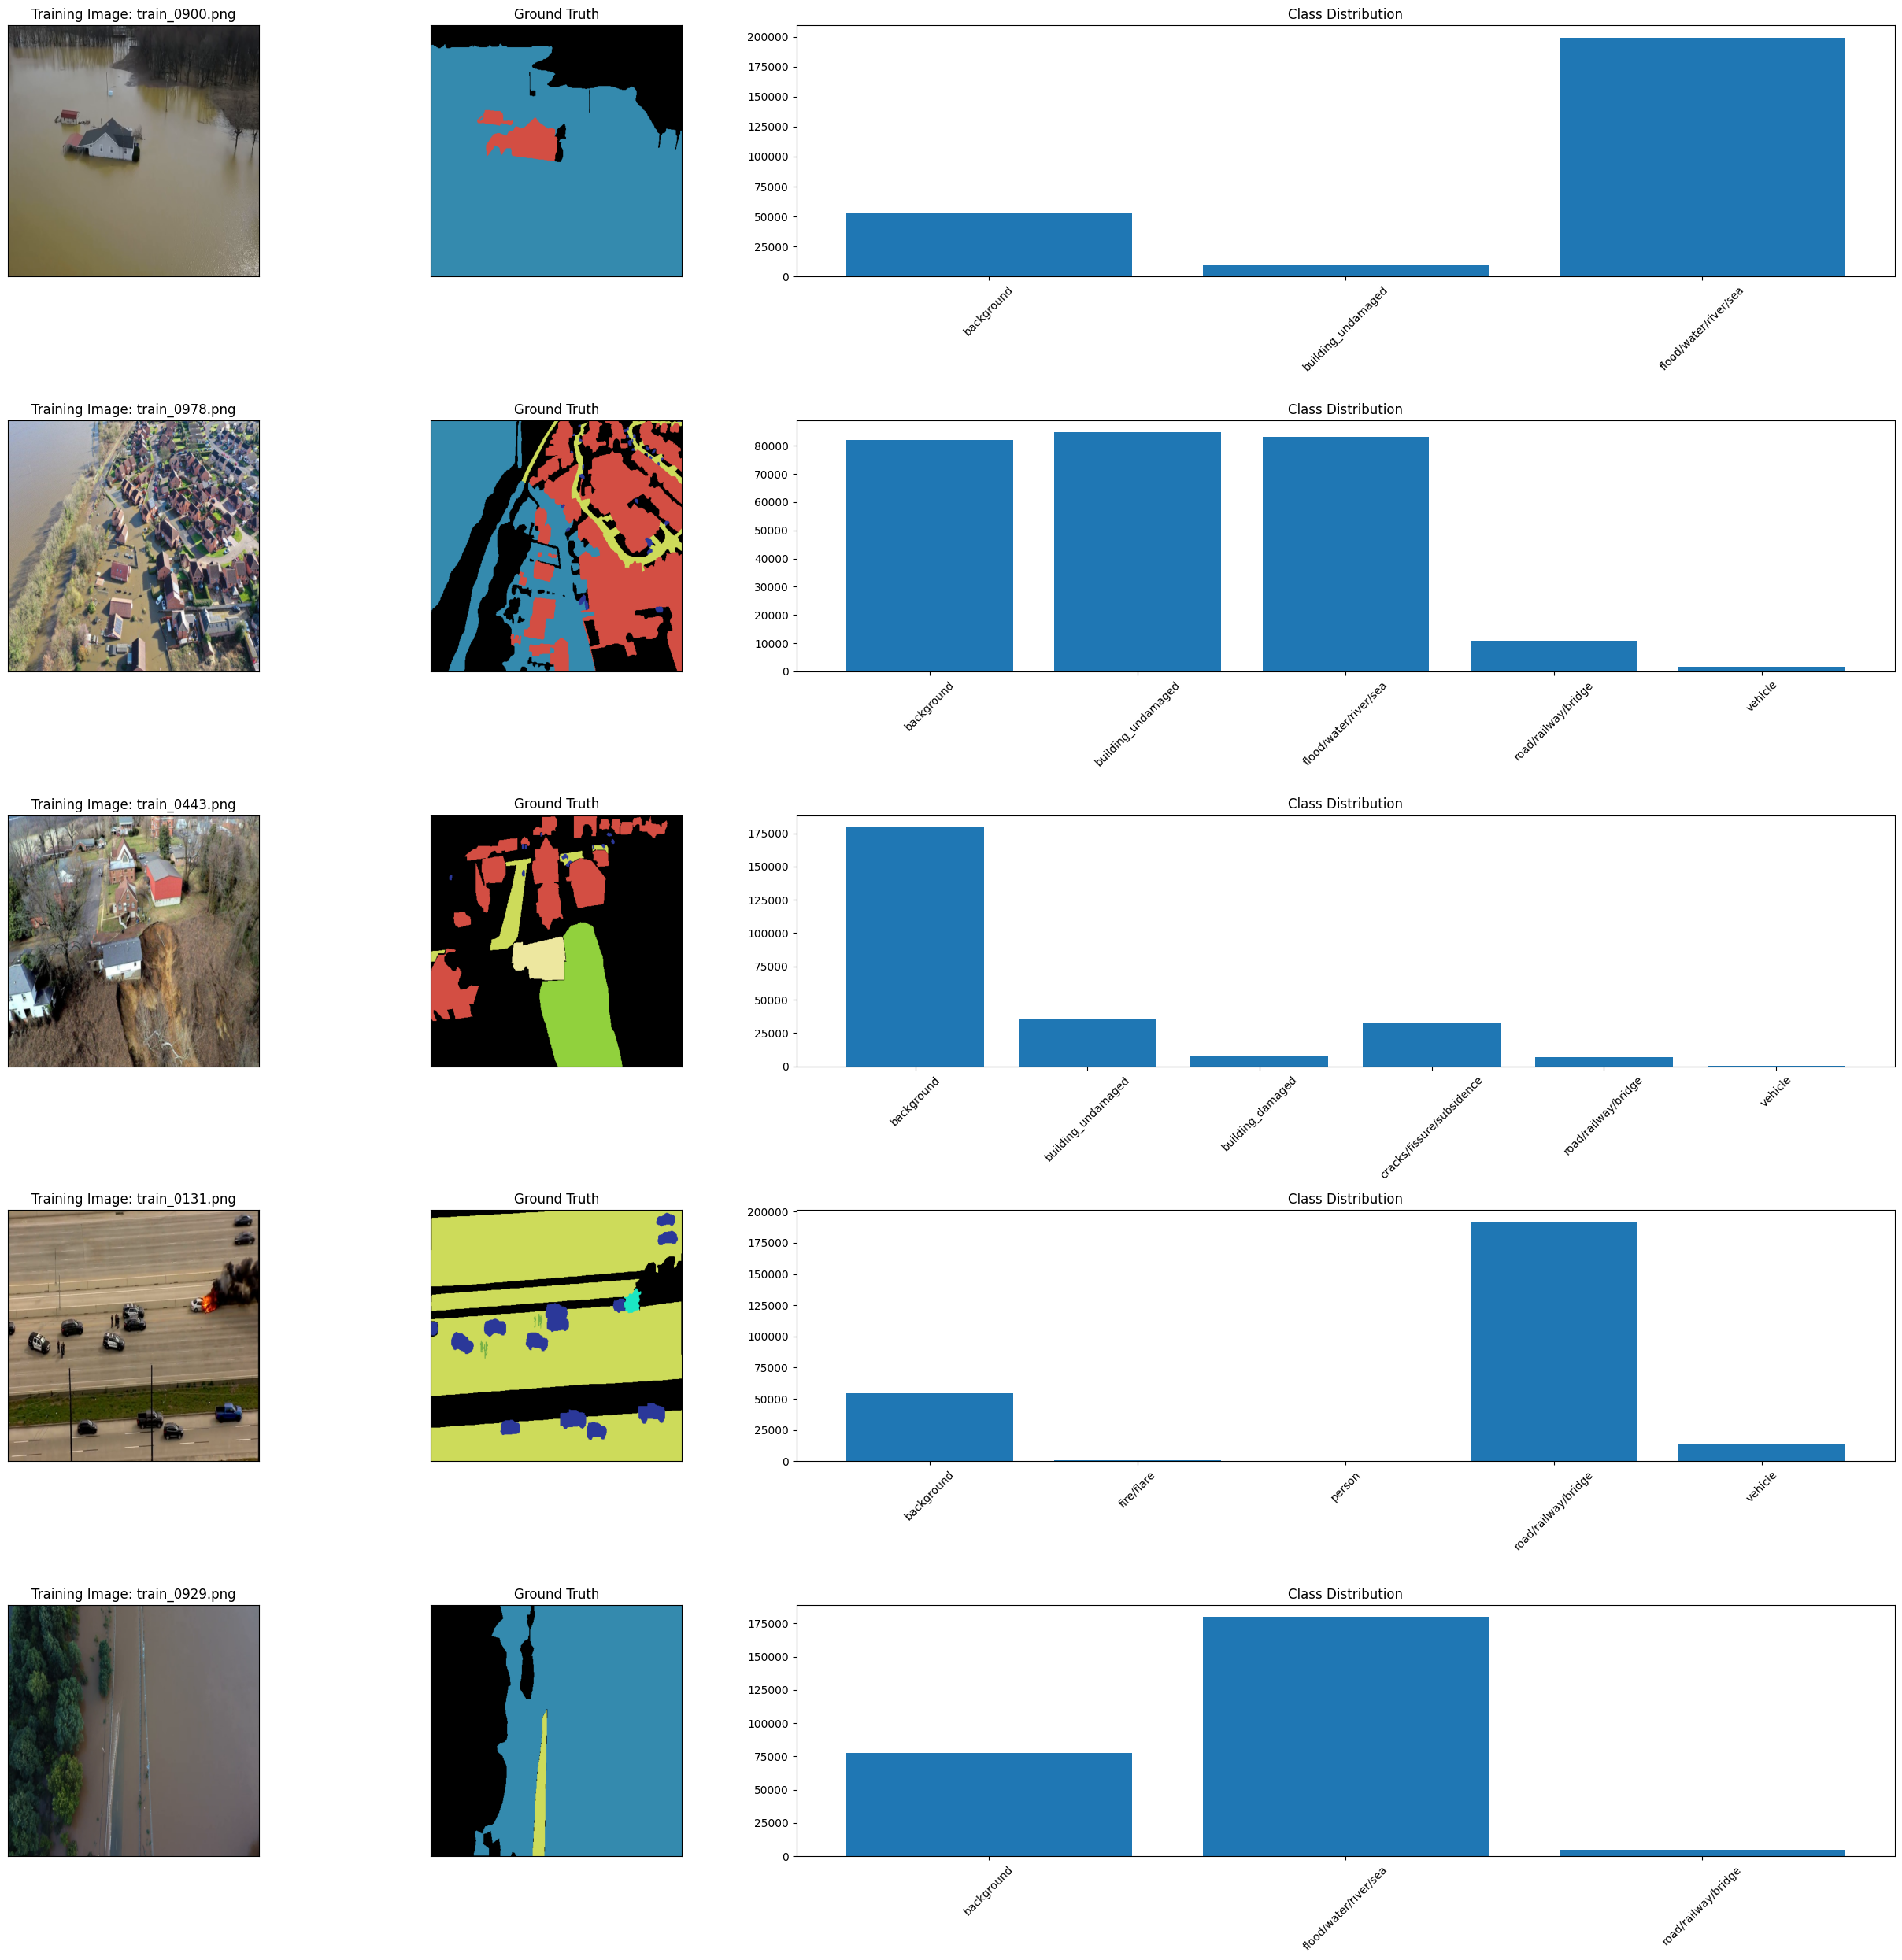

In [78]:
# Try running it again with the debug information
plot_images(train_path, gt_path, num_images=5)

Column 1: Original image  
Column 2: Ground truth segmentation mask where each class is colored according to class_color_maps  
Column 3: Bar plot showing how many pixels belong to each class

In [97]:
def calc_classes_proportions(gt_images_path):
    """
    Calculate the proportion of pixels belonging to each class across all ground truth images.
    
    Args:
        gt_images_path (str): Path to the directory containing ground truth images.
    
    Returns:
        dict: Dictionary of class proportions {class_idx: proportion}.
    """
    t1 = time.time()
    
    # Get all image filenames in the directory
    img_names = [
        f for f in os.listdir(gt_images_path)
        if f.endswith(('.png', '.jpg', '.jpeg'))
    ]
    
    if not img_names:
        raise ValueError(f"No image files found in the directory: {gt_images_path}")
    
    print(f"Found {len(img_names)} images.")
    
    # Initialize pixel counts for each class
    class_counts = {class_idx: 0 for class_idx in class_names.keys()}
    
    # Total pixel count
    total_pixels = 0
    
    for img_name in img_names:
        # Read the ground truth image
        gt_img_path = os.path.join(gt_images_path, img_name)
        gt_img = cv2.imread(gt_img_path, cv2.IMREAD_GRAYSCALE)
        
        if gt_img is None:
            print(f"Warning: Unable to read image {img_name}. Skipping.")
            continue
        
        # Flatten the image for easier counting
        gt_img = gt_img.ravel()
        
        # Update total pixel count
        total_pixels += len(gt_img)
        
        # Count pixels for each class
        for class_idx in class_names:
            class_counts[class_idx] += np.sum(gt_img == int(class_idx))
    
    # Convert counts to proportions
    class_proportions = {
        class_idx: class_counts[class_idx] / total_pixels
        for class_idx in class_counts
    }
    
    print(f"Processing completed in {time.time() - t1:.3f}s.")
    return class_proportions


In [98]:
class_ps = calc_classes_proportions(gt_path)
class_names_to_ps = {
    class_names[class_idx]: class_ps[class_idx]
    for class_idx in class_ps
}
class_names_to_ps


Found 1021 images.
Processing completed in 2.154s.


{'background': 0.6242538624015307,
 'avalanche': 0.013283235435971551,
 'building_undamaged': 0.05180814333924117,
 'building_damaged': 0.03242294281633547,
 'cracks/fissure/subsidence': 0.0489093545134691,
 'debris/mud//rock flow': 0.06460793595122544,
 'fire/flare': 0.007107057487345816,
 'flood/water/river/sea': 0.0633561099778193,
 'ice_jam_flow': 0.01517923711913106,
 'lava_flow': 0.004472839026679955,
 'person': 0.000470474347778679,
 'pyroclastic_flow': 0.014284453359336742,
 'road/railway/bridge': 0.0537863123311819,
 'vehicle': 0.006058041892953064}

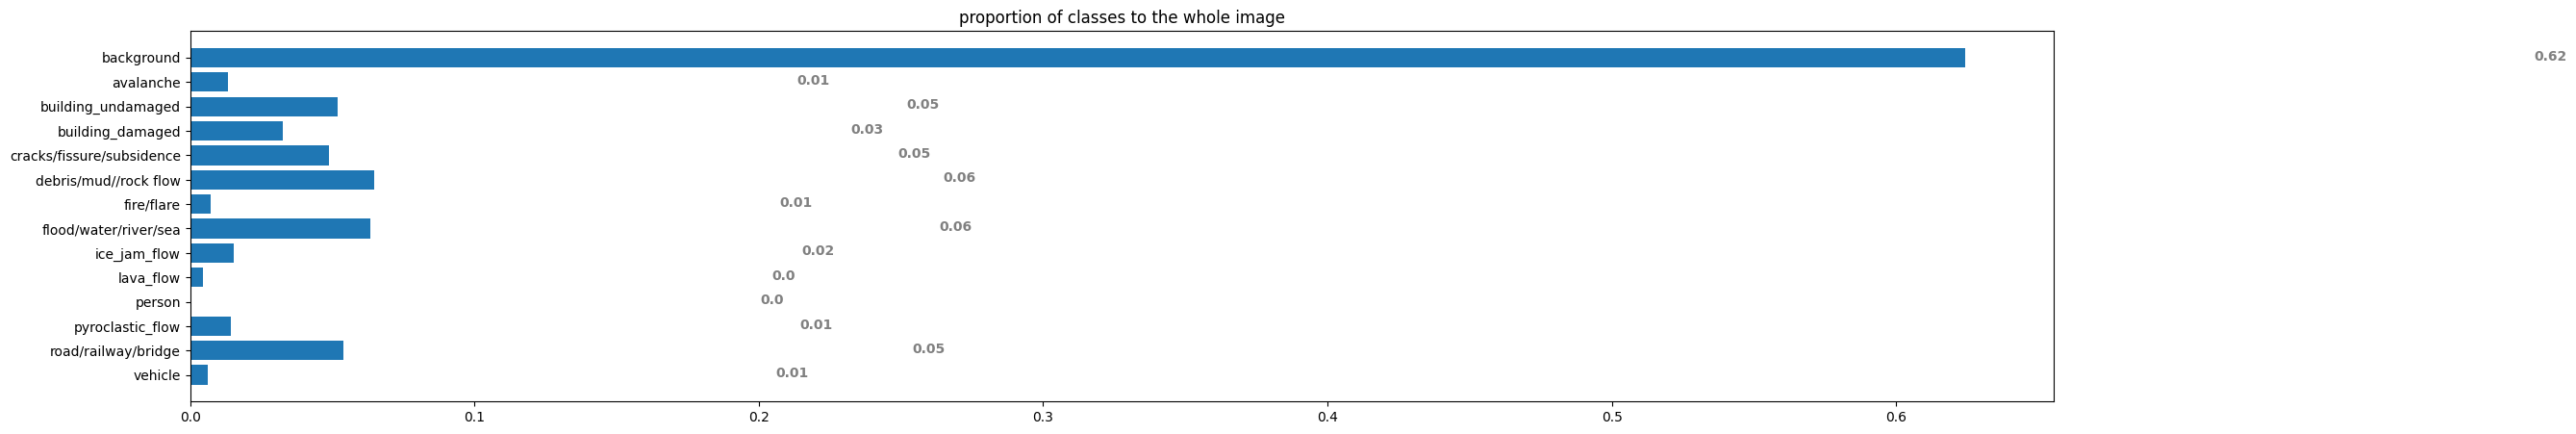

In [99]:
plt.figure(figsize=(25, 5))
plt.barh(list(class_names_to_ps.keys()), list(class_names_to_ps.values()))
plt.gca().set_title('proportion of classes to the whole image')

plt.gca().invert_yaxis()

for i in plt.gca().patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')